Welcome! In this notebook we'll walk through a simple example of how to create a normalizing flow in JAX using Flax!

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output

%matplotlib inline

First, we'll load a dataset of 10,000 2-dimensional points into a matrix $X \in \mathbb{R}^{10000 \times 2}$.

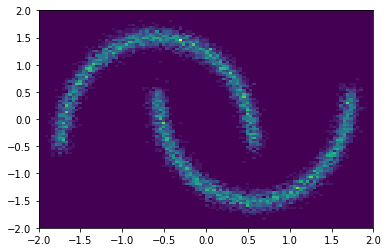

In [2]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

In [3]:
import sys
sys.path.append('..')

import flax

from jax import grad, jit, random
from jax.experimental import optimizers

Next, we'll define some training parameters.

In [4]:
rng = random.PRNGKey(0)
input_shape = X.shape[1:]
num_epochs, batch_size = 500, 100

/Users/chriswaites/miniconda3/envs/exp/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Now it's time to construct the normalizing flow model. We'll opt for a masked autoregressive flow (`MAF`) composed of a sequence of 5 `MADE` blocks.

The core of this library is the concept of a _transformation_. A transformation is characterized by a triplet $(\theta, f_\theta, f^{-1}_\theta)$, where $\theta$ is a parameter vector, and for all $x \in \mathbb{R}^N$, it's the case that $x = f^{-1}_\theta(f_\theta(x))$. Given this characterization, transformations naturally follow a common interface, as described next. 

When you create a transformation, it returns an initialization function `init_fun` which, given a source of randomness `rng` and an `input_shape` tuple returns the aforementioned triplet `(params, normalizing_fun, generative_fun)`.

`params` is consistent with the rest of JAX, and is just a tree of numpy matrices containing all of the trainable parameters of the transformation. More importantly, the `normalizing_fun` and `generative_fun` are the functions which perform direct and inverse transformations according to params. That is, given `params` and `inputs`, each will return `(outputs, logdet)`.

It's worth noting that the composition of several transformations, retrievable by a call to `serial`, is simply a larger, meta-transformation. That is, it adheres to the exact same transformation interface described previously and is indistinguishable from any other transformation.

A _flow_ is such a transformation paired with a prior distribution. A prior distribution should allow one to query the density of a point and sample new points, i.e. it should return `log_prob` and `sample` functions. Typically a normal distribution is used as the prior, and is used as the implicit default parameter when constructing a flow.

In [5]:
params, log_prob, sample = flax.Flow(flax.serial(*(flax.MADE(), flax.Reverse()) * 5), rng, input_shape)

Now, given the model, we can start to optimize it. We can do this by creating a regular JAX Adam optimizer, supplying it the model parameters.

In [6]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-4)
opt_state = opt_init(params)

In [7]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

Now we'll define the loss we'd like to minimize, as well as the step function which will update our parameters given a batch and compile it.

In [8]:
def NLL(params, inputs):
    return -log_prob(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    return opt_update(i, grad(NLL)(params, inputs), opt_state)

And now we train!

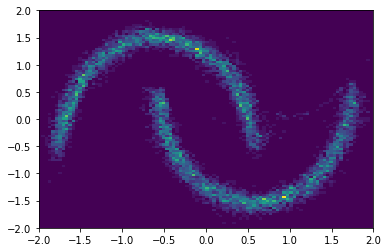

In [ ]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True)

    npr.shuffle(X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
     
    params = get_params(opt_state)
    X_syn = sample(params, X.shape[0])
    
    plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
    plt.show()   
params = get_params(opt_state)

_Magic._